# Project 3
# 2.1
## Project setup:

In [ ]:
from google.colab import drive

import torch
from torch import nn, optim
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd

from collections import defaultdict
import numpy as np
import torchtext
import os
import re
import matplotlib.pyplot as plt


torch.manual_seed(265)
# We use torch.double to get the same results as Pytorch
torch.set_default_dtype(torch.double)
device = (torch.device('cuda')
          if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


## file handling setup

In [ ]:
drive.mount('/content/drive')

base = '/content/drive/MyDrive/Colab Notebooks/project03'
train_folder = f'{base}/data/train/'
val_folder = f'{base}/data/val/'
test_folder = f'{base}/data/test/'
models_folder = f'{base}/models'
models2_folder = f'{base}/models2'
models3_folder = f'{base}/models3'
datasets_folder = f'{base}/datasets'
datasets2_folder = f'{base}/datasets2'
datasets3_folder = f'{base}/datasets3'
embeds_folder = f'{base}/embeds'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## reading in the train, val and test - data

In [ ]:
# tokenizer will split a long text into a list of english words
TOKENIZER_EN = get_tokenizer('basic_english')
# Minimum number of occurence of a word in the text to add it to the vocabulary
MIN_FREQ = 100

def read_files(datapath=train_folder):
    """
    Return a list of strings, one for each line in each .txt files in 'datapath'
    """
    # Find all txt files in directory
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]

    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

def tokenize(lines, tokenizer=TOKENIZER_EN):
    """
    Tokenize the list of lines
    """
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    # Match any word containing digit
    no_digits = '\w*[0-9]+\w*'
    # Match word containing a uppercase
    no_names = '\w*[A-Z]+\w*'
    # Match any sequence containing more than one space
    no_spaces = '\s+'

    for line in lines:
        line = re.sub(no_digits, ' ', line)
        line = re.sub(no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(words, vocab):
    """
    Count occurrences of each word in vocabulary in the data

    Useful to get some insight on the data and to compute loss weights
    """
    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        freqs[vocab[w]] += 1
    return freqs

def create_vocabulary(lines, min_freq=MIN_FREQ):
    """
    Create a vocabulary (list of known tokens) from a list of strings
    """
    # vocab contains the vocabulary found in the data, associating an index to each word
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq, specials=["<unk>"])
    # Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
    vocab.append_token("i")
    # Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
    vocab.set_default_index(vocab["<unk>"])
    return vocab

## tokonizing the data and creating a vocabulary

In [ ]:
# ----------------------- Tokenize texts -------------------------------
# Get lists of strings, one for each line in each .txt files in 'datapath'
lines_books_train = read_files(train_folder)
lines_books_val = read_files(val_folder)
lines_books_test = read_files(test_folder)

# List of words contained in the dataset
words_train = tokenize(lines_books_train)
words_val = tokenize(lines_books_val)
words_test = tokenize(lines_books_test)

# ----------------------- Create vocabulary ----------------------------
# Create vocabulary based on the words in the training dataset
vocab = create_vocabulary(lines_books_train, min_freq=MIN_FREQ)

del lines_books_train
del lines_books_val
del lines_books_test

# ------------------------ Quick analysis ------------------------------
VOCAB_SIZE = len(vocab)
print("Total number of words in the training dataset:     ", len(words_train))
print("Number of distinct words in the training dataset:  ", len(set(words_train)))
print("Number of distinct words kept (vocabulary size):   ", VOCAB_SIZE)

"""
freqs = count_freqs(words_train, vocab)

print("occurences:\n", [(f.item(), w) for (f, w)  in zip(freqs, vocab.lookup_tokens(range(VOCAB_SIZE)))])
del freqs'
"""

Total number of words in the training dataset:      2684706
Number of distinct words in the training dataset:   52105
Number of distinct words kept (vocabulary size):    1880


'\nfreqs = count_freqs(words_train, vocab)\n\nprint("occurences:\n", [(f.item(), w) for (f, w)  in zip(freqs, vocab.lookup_tokens(range(VOCAB_SIZE)))])\ndel freqs\'\n'

## Preprocessing the data to fit the task

In [ ]:
#------------------------ Define targets ------------------------------

# context size for this task
CONTEXT_SIZE = 2


# ---------------- Define context / target pairs -----------------------
def create_dataset(
    text, vocab,
    context_size=CONTEXT_SIZE, map_target=None
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """

    n_text = len(text)
    n_vocab = len(vocab)

    # Change labels if only a few target are kept, otherwise, each word is
    # associated with its index in the vocabulary
    if map_target is None:
        map_target = {i:i for i in range(n_vocab)}

    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(context_size, n_text - context_size):

        t = txt[i]

        c = [txt[j] for j in range(i - context_size, i + context_size + 1) if j != i]

        targets.append(t)
        contexts.append(torch.tensor(c))



    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)

try:
  train_data = torch.load(f'{datasets_folder}/train_data.pt')
  val_data = torch.load(f'{datasets_folder}/val_data.pt')
  test_data = torch.load(f'{datasets_folder}/test_data.pt')
except:
  train_data = create_dataset(words_train, vocab)
  val_data = create_dataset(words_val, vocab)
  test_data = create_dataset(words_test, vocab)

  #Save datasets
  torch.save(train_data, f'{datasets_folder}/train_data.pt')
  torch.save(val_data, f'{datasets_folder}/val_data.pt')
  torch.save(test_data, f'{datasets_folder}/test_data.pt')



##Defining CBOW model, train function and evaluation function

In [ ]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(context_size * 2 * embedding_dim, vocab_size)
        self.train_losses = defaultdict(int)
        self.val_losses = defaultdict(int)

    def forward(self, context):
        embeds = self.embedding(context) # 4 x 10
        flatten = torch.flatten(embeds, 1)# 1x 40
        output = self.linear(flatten)
        return output

In [ ]:
def train(model, loss_fn,optimizer, num_epochs, train_loader, val_loader = None):
    # train the model
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for context, target in train_loader:
            context = context.to(device)
            target = target.to(device)
            # zero the gradients, perform a forward pass, calculate loss, and perform a backward pass
            optimizer.zero_grad()
            outputs = model(context)
            loss = loss_fn(outputs, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}", end = "")
        #Keep track of losses
        model.train_losses[epoch] = total_loss/len(train_loader)
        if type(val_loader) != type(None):
            val_loss = 0
            for context, target in val_loader:
                #Move to GPU
                context = context.to(device)
                target = target.to(device)
                # Sets the gradients of all optimized tensors to zero
                optimizer.zero_grad()
                with torch.no_grad():
                    val_loss += loss_fn(model(context), target).item()
            model.val_losses[epoch] = val_loss/len(val_loader)
            print(f", Val Loss: {val_loss/len(val_loader):.4f}", end = "")
        print()
    return model

In [ ]:
def compute_accuracy(model, loader, device=None):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in loader:
            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs, dim=1)
            total += len(targets)
            correct += int((predicted == targets).sum())

    acc =  correct / total
    return acc

## training some models

In [ ]:
num_epochs = 15
learning_rate = [0.01, 0.1]
weight_decay = [0, 0.001]
embedding_dim = [8, 12]
n_models = 2

#Training models
for i in range(n_models):
  try:
    torch.load(f"{models_folder}/Model{i}.pt")
  except:
    print("Now training model", i+1)
    model = CBOW(VOCAB_SIZE, embedding_dim[i], CONTEXT_SIZE)
    model = model.to(device)

    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate[i], weight_decay=weight_decay[i])
    model = train(model, loss_fn,optimizer, num_epochs, train_data_loader,val_data_loader)
    torch.save(model, f"{models_folder}/Model{i}.pt")

#plotting function

In [ ]:
def plotLoss(model, epochs):
    plt.plot([x for x in range(1,epochs+1)],[model.train_losses[x] for x in model.train_losses])
    plt.plot([x for x in range(1,epochs+1)], [model.val_losses[x] for x in model.val_losses])
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

##Model Selection

In [ ]:
#Find the best model based on validation accuracy
best_model = None
best_acc = 0
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

for i in range(n_models):
    model = torch.load(f"{models_folder}/Model{i}.pt").to('cpu')
    with torch.no_grad():
      print(f"Accuracy for model{i}")
      model.eval()

      #Train accuracy
      acc = compute_accuracy(model, train_data_loader)
      print("Train accuracy:",acc)
      #Validation accuracy
      val_acc = compute_accuracy(model, val_data_loader)

      print("Validation accuracy:", val_acc)
      if val_acc > best_acc:
        best_acc = val_acc
        best_model = model

    print("------------------------------------------------")

Accuracy for model0
Train accuracy: 0.3042687791792162
Validation accuracy: 0.3024110496345059
------------------------------------------------
Accuracy for model1
Train accuracy: 0.22550063284491165
Validation accuracy: 0.21814547069989096
------------------------------------------------


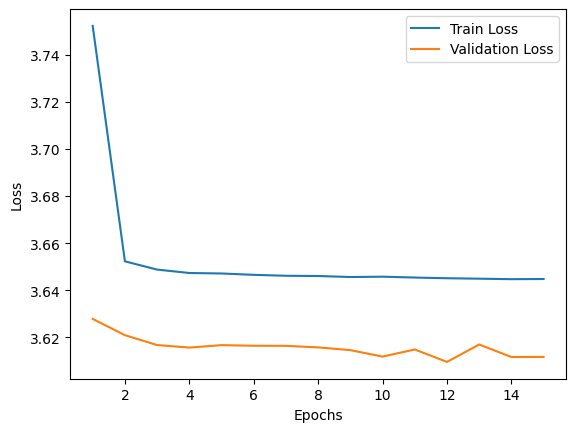

In [ ]:
plotLoss(best_model, num_epochs)

## Model Evaluation

Test data

In [ ]:
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)
acc = compute_accuracy(best_model, test_data_loader)
print(acc)

0.2630489415858491


## Finding cosine similarities between some words

In [ ]:
#Calculate cosine similarity between words
def cosine_similarity(word1, word2, model, vocab):
    word1_idx = vocab[word1]
    word2_idx = vocab[word2]
    word1_vec = model.embedding(torch.tensor([word1_idx]).to('cpu'))
    word2_vec = model.embedding(torch.tensor([word2_idx]).to('cpu'))
    return F.cosine_similarity(word1_vec, word2_vec).item()

some_words = ["eight", "tall", "for", ",", "where"]
for word1 in some_words:
  similar_words = []
  for word2 in vocab.get_itos():
    similar_words.append((cosine_similarity(word1, word2, best_model, vocab), word2))

  similar_words.sort(reverse=True)
  print(f"10 most similar words to '{word1}':")
  for i in range(10):
    print(f"{i+1}. '{similar_words[i][1]}': similarity: {similar_words[i][0]}")
  print("--------------------------------------------------")

10 most similar words to 'eight':
1. 'eight': similarity: 0.9999999999999999
2. 'five': similarity: 0.9622441543750876
3. 'three': similarity: 0.9560670397263983
4. 'fifteen': similarity: 0.9518149588691368
5. 'twelve': similarity: 0.9415286203789088
6. 'six': similarity: 0.9365727320150589
7. 'nine': similarity: 0.93243961698238
8. 'forty': similarity: 0.9316293513423245
9. 'two': similarity: 0.9284123612479194
10. 'four': similarity: 0.918962586527932
--------------------------------------------------
10 most similar words to 'tall':
1. 'tall': similarity: 1.0
2. 'stout': similarity: 0.9432994842639455
3. 'old': similarity: 0.9387193151148641
4. 'infantry': similarity: 0.9266427561141106
5. 'green': similarity: 0.926464877378054
6. 'innocent': similarity: 0.9191892820583982
7. 'honest': similarity: 0.918382106249603
8. 'wide': similarity: 0.8945554597321282
9. 'badly': similarity: 0.8903438060030664
10. 'rich': similarity: 0.8898997158268243
------------------------------------------

In [ ]:
#Exporting the best embedding
model = best_model
embeddings = model.embedding.weight.cpu().detach().numpy()
embeds = pd.DataFrame(embeddings)
embeds.to_csv(f'{embeds_folder}/embeds1.tsv', sep="\t", header=False, index=False)

w = list(vocab.get_itos())
w = pd.DataFrame(w)
w.to_csv(f'{embeds_folder}/words1.tsv', sep="\t", header=False, index=False)

#2.3

## Preprocessing the data

In [ ]:
#------------------------ Define targets ------------------------------

# context size for this task
CONTEXT_SIZE = 12


# ---------------- Define context / target pairs -----------------------
def create_dataset(
    text, vocab,
    context_size=CONTEXT_SIZE
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """

    n_text = len(text)
    n_vocab = len(vocab)


    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(context_size, n_text - context_size):
        if txt[i] == 0:
               continue
        t = txt[i]

        c = [txt[j] for j in range(i - context_size, i)]

        targets.append(t)
        contexts.append(torch.tensor(c))

    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)

try:
  train_data = torch.load(f'{datasets3_folder}/train_data.pt')
  val_data = torch.load(f'{datasets3_folder}/val_data.pt')
  test_data = torch.load(f'{datasets3_folder}/test_data.pt')
except:
  train_data = create_dataset(words_train, vocab)
  val_data = create_dataset(words_val, vocab)
  test_data = create_dataset(words_test, vocab)

  #Save datasets
  torch.save(train_data, f'{datasets3_folder}/train_data.pt')
  torch.save(val_data, f'{datasets3_folder}/val_data.pt')
  torch.save(test_data, f'{datasets3_folder}/test_data.pt')

## setting up the model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix, embedding_dim, hidden_dim, vocab_size):
        super(LSTM, self).__init__()

        # Define the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Load the pre-trained embedding matrix
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

        # Define the LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Define the linear layer to map from hidden state to output
        self.fc1 = nn.Linear(hidden_dim, vocab_size)

        self.train_losses = defaultdict(int)
        self.val_losses = defaultdict(int)

    def forward(self, x, h=None):
        x = self.embedding(x)
        output, (h_n, c_n) = self.lstm(x)
        out = self.fc1(h_n[-1])
        return out

## Model evaluation

In [ ]:
num_epochs = 5
learning_rate = [0.01, 0.1]
weight_decay = [0, 0.001]
n_models = 2

#Training models
for i in range(n_models):
  try:
    torch.load(f"{models3_folder}/Model{i}.pt")
  except:
    print("Now training model", i+1)
    model = LSTM(embeddings, embeddings.shape[1], CONTEXT_SIZE, VOCAB_SIZE)
    model = model.to(device)

    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=192, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=192, shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate[i], weight_decay=weight_decay[i])
    model = train(model, loss_fn,optimizer, num_epochs, train_data_loader,val_data_loader)
    torch.save(model, f"{models3_folder}/Model{i}.pt")

In [ ]:
#Find the best model based on validation accuracy
best_model = None
best_acc = 0
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

for i in range(n_models):
    model = torch.load(f"{models3_folder}/Model{i}.pt").to('cpu')
    with torch.no_grad():
      print(f"Accuracy for model{i}")
      model.eval()

      #Train accuracy
      acc = compute_accuracy(model, train_data_loader)
      print("Train accuracy:",acc)
      #Validation accuracy
      val_acc = compute_accuracy(model, val_data_loader)

      print("Validation accuracy:", val_acc)
      if val_acc > best_acc:
        best_acc = val_acc
        best_model = model

    print("------------------------------------------------")

Accuracy for model0
Train accuracy: 0.19099148251207027
Validation accuracy: 0.18063332459672615
------------------------------------------------
Accuracy for model1
Train accuracy: 0.13232029237851217
Validation accuracy: 0.12390097452881889
------------------------------------------------


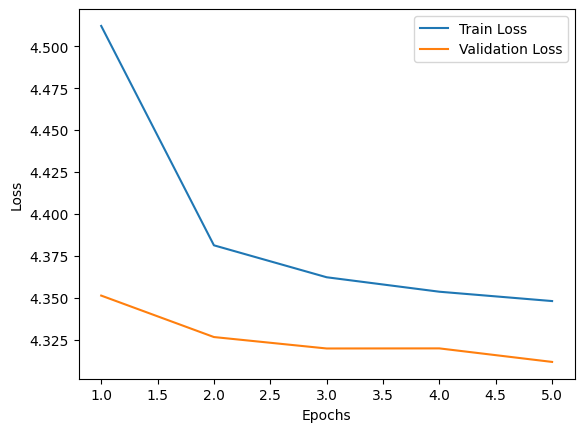

In [ ]:
plotLoss(best_model, num_epochs)

## Model selection

In [ ]:
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)
acc = compute_accuracy(best_model, test_data_loader)
print(acc)

0.14605403999479807


## Implementing beam search

In [ ]:
def beam_search(model, context, beam_size, max_len):
    # Set the model to evaluation mode
    model.eval()

    context = [vocab[w] for w in tokenize(context)]
    paths = [(0, context)]
    with torch.no_grad():

        for i in range(max_len):
            new_paths = []
            for path in paths:
                # Run the forward pass to get the initial logits
                context = path[1]
                logits = model(torch.tensor([context]))
                predseq = F.softmax(logits, dim = 1)
                probs, words = torch.topk(predseq, k = beam_size, dim = 1)

                new_paths+= ([(path[0] + (torch.log(prob)).item(), context+ [word.item()]) for prob, word in zip(probs.squeeze(), words.squeeze())])
            paths = sorted(new_paths, reverse = True)[:beam_size]

        words = list(vocab.get_itos())
        sentence = " ".join(words[idx] for idx in paths[0][1])
        return sentence


## Testing some words

In [ ]:
beam_search(best_model, ["The man was "], 10, 10)

'the man was a few minutes . it was a few minutes ,'

In [ ]:
beam_search(best_model, ["one two three"], 10, 10)

'one two three o clock . then . . . . . .'

In [ ]:
beam_search(best_model, ["old man"], 10 ,10)

'old man went north . then , the king s son ,'

In [ ]:
beam_search(best_model, ["one day, they all"], 10 ,15)

'one day , they all went to the door , and the king was a few minutes , and the'

In [ ]:
beam_search(best_model, ["ask her to marry"], 30 ,5)

'ask her to marry me , said he ,'

In [ ]:
beam_search(best_model, ["what is going on"], 20, 20)

#2.2

## Pre Processing the data to fit the task

In [ ]:
#------------------------ Define targets ------------------------------

# context size for this task
CONTEXT_SIZE = 2

map_targets = {"be":0, "am":1, "are":2, "is":3, "was":4, "were":5, "been":6, "being": 7, "have":8, "has":9, "had":10, "having":11}
# ---------------- Define context / target pairs -----------------------
def create_dataset(
    text, vocab,
    context_size=CONTEXT_SIZE,
    map_targets = map_targets
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """

    n_text = len(text)
    n_vocab = len(vocab)


    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(context_size, n_text - context_size):
        if not text[i] in map_targets:
               continue
        t = map_targets[text[i]]

        c = [txt[j] for j in range(i - context_size, i + context_size + 1) if j != i]

        targets.append(t)
        contexts.append(torch.tensor(c))



    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)

try:
  train_data = torch.load(f'{datasets2_folder}/train_data.pt')
  val_data = torch.load(f'{datasets2_folder}/val_data.pt')
  test_data = torch.load(f'{datasets2_folder}/test_data.pt')
except:
  train_data = create_dataset(words_train, vocab, CONTEXT_SIZE, map_targets)
  val_data = create_dataset(words_val, vocab, CONTEXT_SIZE, map_targets)
  test_data = create_dataset(words_test, vocab, CONTEXT_SIZE, map_targets)

  #Save datasets
  torch.save(train_data, f'{datasets2_folder}/train_data.pt')
  torch.save(val_data, f'{datasets2_folder}/val_data.pt')
  torch.save(test_data, f'{datasets2_folder}/test_data.pt')

## Setting up models

In [ ]:
class RNN(nn.Module):
    def __init__(self, embedding_matrix, embedding_dim, context_size, vocab_size):

        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.linear = nn.Linear(context_size * 2 * embedding_dim, 12)
        self.train_losses = defaultdict(int)
        self.val_losses = defaultdict(int)


    def forward(self, context):
        embeds = self.embedding(context) # 4 x 10
        flatten = torch.flatten(embeds, 1)# 1x 40
        output = self.linear(flatten)
        return output

In [ ]:
class MLP(nn.Module):
    def __init__(self, embedding_matrix, embedding_dim, context_size, vocab_size):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.fc1 = nn.Linear(embedding_dim, context_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(context_size, 12)
        self.train_losses = defaultdict(int)
        self.val_losses = defaultdict(int)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1) # Average the embeddings across the sequence length
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Model evaluation for the RNN architecture

In [ ]:
num_epochs = 5
learning_rate = [0.01, 0.1]
weight_decay = [0, 0.001]
n_models = 2

#Training models
for i in range(n_models):
  try:
    torch.load(f"{models2_folder}/ModelRNN{i}.pt")
  except:
    print("Now training modelRNN", i+1)
    model = RNN(embeddings, embeddings.shape[1], CONTEXT_SIZE, VOCAB_SIZE)
    model = model.to(device)

    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=192, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=192, shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate[i], weight_decay=weight_decay[i])
    model = train(model, loss_fn,optimizer, num_epochs, train_data_loader,val_data_loader)
    torch.save(model, f"{models2_folder}/ModelRNN{i}.pt")

Now training modelRNN 1
Epoch 1/5, Train Loss: 1.2029, Val Loss: 1.0722
Epoch 2/5, Train Loss: 1.0265, Val Loss: 1.0454
Epoch 3/5, Train Loss: 1.0027, Val Loss: 1.0310
Epoch 4/5, Train Loss: 0.9911, Val Loss: 1.0511
Epoch 5/5, Train Loss: 0.9854, Val Loss: 1.0437
Now training modelRNN 2
Epoch 1/5, Train Loss: 1.3017, Val Loss: 1.2059
Epoch 2/5, Train Loss: 1.2811, Val Loss: 1.2630
Epoch 3/5, Train Loss: 1.2810, Val Loss: 1.2360
Epoch 4/5, Train Loss: 1.2805, Val Loss: 1.2323
Epoch 5/5, Train Loss: 1.2784, Val Loss: 1.2568


In [ ]:
#Find the best model based on validation accuracy
best_RNNmodel = None
best_acc = 0
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

for i in range(n_models):
    model = torch.load(f"{models2_folder}/ModelRNN{i}.pt").to('cpu')
    with torch.no_grad():
      print(f"Accuracy for model{i}")
      model.eval()

      #Train accuracy
      acc = compute_accuracy(model, train_data_loader)
      print("Train accuracy:",acc)
      #Validation accuracy
      val_acc = compute_accuracy(model, val_data_loader)

      print("Validation accuracy:", val_acc)
      if val_acc > best_acc:
        best_acc = val_acc
        best_RNNmodel = model

    print("------------------------------------------------")

Accuracy for model0
Train accuracy: 0.6370987898186744
Validation accuracy: 0.6034749034749035
------------------------------------------------
Accuracy for model1
Train accuracy: 0.5293273455829591
Validation accuracy: 0.5339768339768339
------------------------------------------------


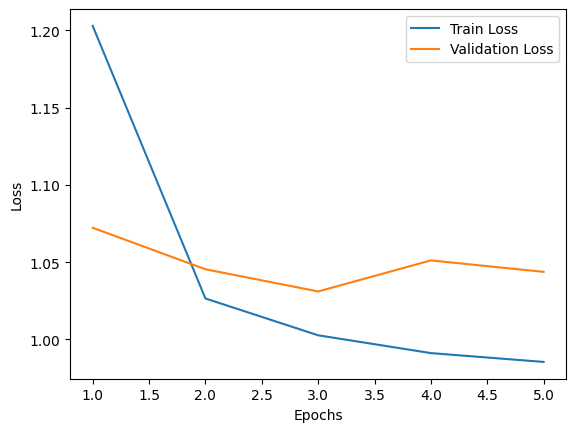

In [ ]:
plotLoss(best_RNNmodel, num_epochs)

## Model evaluation for the MLP architecture

In [ ]:
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)
acc = compute_accuracy(best_RNNmodel, test_data_loader)
print(acc)

0.4738719832109129


In [ ]:
num_epochs = 5
learning_rate = [0.01, 0.1]
weight_decay = [0, 0.001]
n_models = 2

#Training models
for i in range(n_models):
  try:
    torch.load(f"{models2_folder}/ModelMLP{i}.pt")
  except:
    print("Now training modelMLP", i+1)
    model = MLP(embeddings, embeddings.shape[1], CONTEXT_SIZE, VOCAB_SIZE)
    model = model.to(device)

    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=192, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=192, shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate[i], weight_decay=weight_decay[i])
    model = train(model, loss_fn,optimizer, num_epochs, train_data_loader,val_data_loader)
    torch.save(model, f"{models2_folder}/ModelMLP{i}.pt")

Now training modelMLP 1
Epoch 1/5, Train Loss: 1.7254, Val Loss: 1.5503
Epoch 2/5, Train Loss: 1.5163, Val Loss: 1.4953
Epoch 3/5, Train Loss: 1.4744, Val Loss: 1.4764
Epoch 4/5, Train Loss: 1.4632, Val Loss: 1.4666
Epoch 5/5, Train Loss: 1.4576, Val Loss: 1.4490
Now training modelMLP 2
Epoch 1/5, Train Loss: 1.7156, Val Loss: 1.6627
Epoch 2/5, Train Loss: 1.6419, Val Loss: 1.5894
Epoch 3/5, Train Loss: 1.6261, Val Loss: 1.5849
Epoch 4/5, Train Loss: 1.6226, Val Loss: 1.5972
Epoch 5/5, Train Loss: 1.6235, Val Loss: 1.5721


In [ ]:
#Find the best model based on validation accuracy
best_MLPmodel = None
best_acc = 0
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

for i in range(n_models):
    model = torch.load(f"{models2_folder}/ModelMLP{i}.pt").to('cpu')
    with torch.no_grad():
      print(f"Accuracy for model{i}")
      model.eval()

      #Train accuracy
      acc = compute_accuracy(model, train_data_loader)
      print("Train accuracy:",acc)
      #Validation accuracy
      val_acc = compute_accuracy(model, val_data_loader)

      print("Validation accuracy:", val_acc)
      if val_acc > best_acc:
        best_acc = val_acc
        best_MLPmodel = model

    print("------------------------------------------------")

Accuracy for model0
Train accuracy: 0.4919334682458418
Validation accuracy: 0.5057915057915058
------------------------------------------------
Accuracy for model1
Train accuracy: 0.4212656513291032
Validation accuracy: 0.4640926640926641
------------------------------------------------


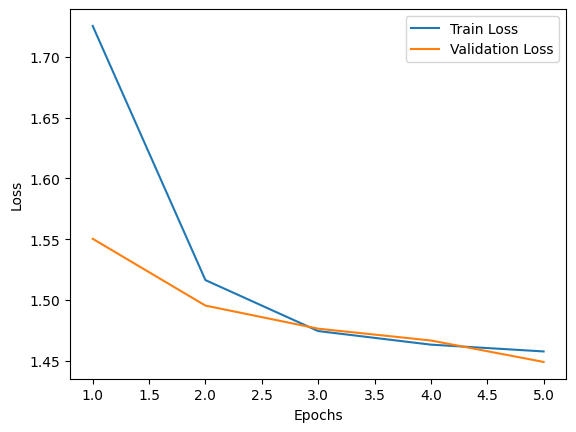

In [ ]:
plotLoss(best_MLPmodel, num_epochs)

## Model evaluation

In [ ]:
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)
acc = compute_accuracy(best_MLPmodel, test_data_loader)
print(acc)

0.45078698845750265
